- Please run this notebook on Google Colab under a directory named Data_101_Final_Project, which contains yelp_dataset.tar file (i.e. we need path '/content/drive/MyDrive/Data_101_Final_Project/yelp_dataset.tar')

## SETUP FOR POSTGRESQL AND DRIVE IMPORTS

In [1]:
# Install PostgreSQL
!sudo apt-get update
!sudo apt-get install postgresql postgresql-contrib -y

# Start PostgreSQL service
!sudo service postgresql start

# Create a user and a database
!sudo -u postgres psql -c "CREATE USER myuser WITH PASSWORD 'mypassword';"
!sudo -u postgres psql -c "CREATE DATABASE data101db;"
!sudo -u postgres psql -c "GRANT ALL PRIVILEGES ON DATABASE data101db TO myuser;"

!pip install psycopg2-binary
!pip install pymongo

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 https://repo.mongodb.org/apt/ubuntu focal/mongodb-org/4.4 InRelease
Hit:7 https://repo.mongodb.org/apt/ubuntu focal/mongodb-org/5.0 InRelease
Get:8 https://repo.mongodb.org/apt/ubuntu jammy/mongodb-org/6.0 InRelease [4,009 B]
Hit:9 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:14 http://archive.ubuntu.com/ubu

In [2]:
# Import required libraries
import psycopg2
import pandas as pd
import json
import tarfile

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Connect to PostgreSQL database
conn = psycopg2.connect(
        dbname="data101db",
        user="myuser",
        password="mypassword",
        host="localhost",
        port="5432"  # Default PostgreSQL port
)
cur = conn.cursor()
print("Database connection established!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Database connection established!


In [ ]:

# DO NOT NEED TO SAVE FILE AGAIN
# first time run this to unzip tar file

# # Path to the .tar file in Google Drive
# tar_file_path = '/content/drive/MyDrive/Data_101_Final_Project/yelp_dataset.tar'

# # Path to extract the contents
# extract_path = '/content/drive/My Drive/Data_101_Final_Project/yelp_dataset_extracted'

# # Extract files from the tar file
# with tarfile.open(tar_file_path, 'r') as tar:
#     tar.extractall(path=extract_path)

# print(f"Files extracted to {extract_path}")


# Yelp Dataset Sampling and PostgreSQL Integration

### Description
This script processes the Yelp dataset by sampling, filtering, and loading data into a PostgreSQL database. It creates normalized tables (`Businesses`, `Users`, and `Reviews`), indexes for performance, and ensures data integrity by handling only relevant records. The script also verifies row counts for validation, making it ideal for handling large-scale datasets efficiently.

In [4]:

from psycopg2.extras import execute_values
from io import StringIO
from joblib import Parallel, delayed

# Path to extract the contents
extract_path = '/content/drive/My Drive/Data_101_Final_Project/yelp_dataset_extracted'

# Load all datasets from JSON
business_path = f'{extract_path}/yelp_academic_dataset_business.json'
user_path = f'{extract_path}/yelp_academic_dataset_user.json'
review_path = f'{extract_path}/yelp_academic_dataset_review.json'


# Display schemas of the datasets
print("Dataset columns:")
print("Business columns:", pd.read_json(business_path, lines=True, nrows=1).columns)
print("User columns:", pd.read_json(user_path, lines=True, nrows=1).columns)
print("Review columns:", pd.read_json(review_path, lines=True, nrows=1).columns)

import psycopg2
import pandas as pd
import json
try:
    conn = psycopg2.connect(
        dbname="data101db",
        user="myuser",
        password="mypassword",
        host="localhost",
        port="5432"
    )
    cur = conn.cursor()
    print("Database connection established!")
except Exception as e:
    print(f"Error: Database connection failed - {e}")
    raise

# PostgreSQL schema creation queries
schema_queries = """
DROP TABLE IF EXISTS Reviews CASCADE;
DROP TABLE IF EXISTS Users CASCADE;
DROP TABLE IF EXISTS Businesses CASCADE;

CREATE TABLE Businesses (
    business_id VARCHAR PRIMARY KEY,
    name TEXT,
    address TEXT,
    city TEXT,
    state TEXT,
    postal_code TEXT,
    latitude FLOAT,
    longitude FLOAT,
    stars FLOAT,
    review_count INT,
    is_open BOOLEAN,
    attributes JSONB,
    categories TEXT,
    hours JSONB
);

CREATE TABLE Users (
    user_id VARCHAR PRIMARY KEY,
    name TEXT,
    review_count INT,
    yelping_since VARCHAR,  -- Changed to VARCHAR for flexibility
    friends TEXT,
    useful INT,
    funny INT,
    cool INT,
    fans INT,
    elite TEXT,
    average_stars FLOAT,
    compliment_hot INT,
    compliment_more INT,
    compliment_profile INT,
    compliment_cute INT,
    compliment_list INT,
    compliment_note INT,
    compliment_plain INT,
    compliment_cool INT,
    compliment_funny INT,
    compliment_writer INT,
    compliment_photos INT
);

CREATE TABLE Reviews (
    review_id VARCHAR PRIMARY KEY,
    user_id VARCHAR REFERENCES Users(user_id),
    business_id VARCHAR REFERENCES Businesses(business_id),
    stars INT,
    useful INT,
    funny INT,
    cool INT,
    text TEXT,
    review_date DATE
);

-- Add indexes to improve performance
CREATE INDEX idx_reviews_user_id ON Reviews(user_id);
CREATE INDEX idx_reviews_business_id ON Reviews(business_id);
"""

try:
    cur.execute(schema_queries)
    conn.commit()
    print("Schema replaced successfully!")
except Exception as e:
    conn.rollback()
    print(f"Error: Failed to create schema - {e}")
    raise

# Step 1: Sample Businesses
def sample_businesses(file_path, sample_size=20000):
    sampled_df = pd.DataFrame()
    for chunk in pd.read_json(file_path, lines=True, chunksize=50000):  # Increased chunksize
        remaining_size = sample_size - len(sampled_df)
        if remaining_size <= 0:
            break
        sampled_df = pd.concat([sampled_df, chunk.sample(n=min(remaining_size, len(chunk)), random_state=42)])
    print(f"Sampled {len(sampled_df)} businesses.")
    return sampled_df

sampled_business_df = sample_businesses(business_path)

def load_sampled_businesses(df, conn):
    # Prepare the data
    rows = [
        (
            row['business_id'], row['name'], row['address'], row['city'], row['state'], row['postal_code'],
            row['latitude'], row['longitude'], row['stars'], row['review_count'],
            bool(row['is_open']) if pd.notnull(row['is_open']) else None,
            json.dumps(row['attributes']) if isinstance(row['attributes'], dict) else None,
            row['categories'],
            json.dumps(row['hours']) if isinstance(row['hours'], dict) else None
        )
        for _, row in df.iterrows()
    ]

    insert_query = """
        INSERT INTO Businesses (
            business_id, name, address, city, state, postal_code, latitude, longitude,
            stars, review_count, is_open, attributes, categories, hours
        ) VALUES %s
        ON CONFLICT (business_id) DO NOTHING;
    """

    with conn.cursor() as cur:
        execute_values(cur, insert_query, rows)
    conn.commit()
    print("Sampled businesses loaded successfully.")

load_sampled_businesses(sampled_business_df, conn)

# Step 2: Filter and Load Users Related to Sampled Businesses
def get_relevant_user_ids(review_path, business_ids):
    user_ids = set()
    for chunk in pd.read_json(review_path, lines=True, chunksize=100000):
        filtered = chunk[chunk['business_id'].isin(business_ids)]
        user_ids.update(filtered['user_id'].unique())
    print(f"Found {len(user_ids)} relevant users.")
    return user_ids

relevant_user_ids = get_relevant_user_ids(review_path, set(sampled_business_df['business_id']))

def load_users(file_path, relevant_user_ids, conn):
    insert_query = """
        INSERT INTO Users (
            user_id, name, review_count, yelping_since, friends, useful, funny, cool, fans, elite,
            average_stars, compliment_hot, compliment_more, compliment_profile, compliment_cute,
            compliment_list, compliment_note, compliment_plain, compliment_cool, compliment_funny,
            compliment_writer, compliment_photos
        ) VALUES %s
        ON CONFLICT (user_id) DO NOTHING;
    """
    chunksize = 50000  # Increased chunksize
    for chunk in pd.read_json(file_path, lines=True, chunksize=chunksize):
        filtered_chunk = chunk[chunk['user_id'].isin(relevant_user_ids)]
        rows = []
        for _, row in filtered_chunk.iterrows():
            try:
                # Handle potential data issues
                yelping_since = row['yelping_since']
                friends = ','.join(row['friends']) if isinstance(row['friends'], list) else row['friends']
                elite = ','.join(row['elite']) if isinstance(row['elite'], list) else row['elite']
                rows.append((
                    row['user_id'], row['name'], row['review_count'], yelping_since, friends, row['useful'],
                    row['funny'], row['cool'], row['fans'], elite, row['average_stars'],
                    row['compliment_hot'], row['compliment_more'], row['compliment_profile'],
                    row['compliment_cute'], row['compliment_list'], row['compliment_note'],
                    row['compliment_plain'], row['compliment_cool'], row['compliment_funny'],
                    row['compliment_writer'], row['compliment_photos']
                ))
            except Exception as e:
                print(f"Error processing user_id {row['user_id']}: {e}")

        if rows:
            with conn.cursor() as cur:
                try:
                    execute_values(cur, insert_query, rows)
                    conn.commit()
                    print(f"Processed {len(rows)} users.")
                except Exception as e:
                    conn.rollback()
                    print(f"Error inserting batch: {e}")

load_users(user_path, relevant_user_ids, conn)

def verify_users_loaded(relevant_user_ids, conn):
    with conn.cursor() as cur:
        cur.execute("SELECT user_id FROM Users WHERE user_id = ANY(%s);", (list(relevant_user_ids),))
        loaded_user_ids = set(row[0] for row in cur.fetchall())
        missing_user_ids = relevant_user_ids - loaded_user_ids
        if missing_user_ids:
            print(f"Missing {len(missing_user_ids)} user IDs in Users table.")
        else:
            print("All relevant user IDs are loaded in the Users table.")

verify_users_loaded(relevant_user_ids, conn)

# Step 3: Load Reviews Related to Sampled Businesses and Users
def load_reviews(file_path, business_ids, conn):
    # Fetch valid user IDs from the database
    with conn.cursor() as cur:
        cur.execute("SELECT user_id FROM Users;")
        valid_user_ids = set(row[0] for row in cur.fetchall())

    insert_query = """
        INSERT INTO Reviews (
            review_id, user_id, business_id, stars, useful, funny, cool, text, review_date
        ) VALUES %s
        ON CONFLICT (review_id) DO NOTHING;
    """

    chunksize = 50000  # Increased chunksize
    for chunk in pd.read_json(file_path, lines=True, chunksize=chunksize):
        # Filter reviews for valid business and user IDs
        filtered_reviews = chunk[
            chunk['business_id'].isin(business_ids) &
            chunk['user_id'].isin(valid_user_ids)
        ]

        rows = [
            (
                row['review_id'], row['user_id'], row['business_id'], row['stars'], row['useful'], row['funny'],
                row['cool'], row['text'], pd.to_datetime(row['date']).date()
            )
            for _, row in filtered_reviews.iterrows()
        ]

        if rows:
            with conn.cursor() as cur:
                execute_values(cur, insert_query, rows)
            conn.commit()
            print(f"Processed {len(rows)} reviews.")

load_reviews(review_path, set(sampled_business_df['business_id']), conn)

# Verify Row Counts
def verify_row_count(table_name, conn):
    with conn.cursor() as cur:
        cur.execute(f"SELECT COUNT(*) FROM {table_name};")
        count = cur.fetchone()[0]
        print(f"{table_name} table row count: {count}")

print("\nVerifying row counts:")
verify_row_count("Businesses", conn)
verify_row_count("Users", conn)
verify_row_count("Reviews", conn)

# Close Connection
cur.close()
conn.close()
print("Database connection closed.")

Dataset columns:
Business columns: Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')
User columns: Index(['user_id', 'name', 'review_count', 'yelping_since', 'useful', 'funny',
       'cool', 'elite', 'friends', 'fans', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos'],
      dtype='object')
Review columns: Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')
Database connection established!
Schema replaced successfully!
Sampled 20000 businesses.
Sampled businesses loaded successfully.
Found 532171 relevant users.
Processed 36589 users.
Processed 34

# PostgreSQL Query Analysis with EXPLAIN ANALYZE

### Description
This script connects to a PostgreSQL database and executes multiple queries to analyze dataset performance. It uses `EXPLAIN ANALYZE` to provide execution details for each query, including runtime and plan details. The script is ideal for optimizing SQL queries and understanding database performance metrics.

In [5]:
import psycopg2
import time
import pprint

# PostgreSQL connection
try:
    conn = psycopg2.connect(
        dbname="data101db",
        user="myuser",
        password="mypassword",
        host="localhost",
        port="5432"
    )
    pg_cur = conn.cursor()
    print("PostgreSQL connection established!")
except Exception as e:
    print(f"Error: PostgreSQL connection failed - {e}")
    raise

# Function to print results nicely
def print_results(results):
    for result in results:
        pprint.pprint(result)

# Query 1: Cities with High Restaurant Rating Activity
print("=== Query 1: Cities with High Restaurant Rating Activity ===\n")
sql_query1 = """
EXPLAIN ANALYZE
SELECT
    b.city,
    COUNT(r.review_id) AS total_reviews,
    AVG(r.stars) AS avg_rating
FROM
    Businesses b
JOIN
    Reviews r
ON
    b.business_id = r.business_id
WHERE
    b.categories ILIKE '%Restaurant%'
GROUP BY
    b.city
ORDER BY
    total_reviews DESC
LIMIT 10;
"""
start_time = time.time()
pg_cur.execute(sql_query1)
pg_results = pg_cur.fetchall()
pg_time = time.time() - start_time
print(f"PostgreSQL Query Execution Time: {pg_time:.4f} seconds\n")
print("PostgreSQL EXPLAIN ANALYZE Results:")
print_results(pg_results)

# Query 2: Highly Rated Restaurants with Specific Features
print("\n=== Query 2: Highly Rated Restaurants with Specific Features ===\n")
sql_query2 = """
EXPLAIN ANALYZE
SELECT DISTINCT
    b.name,
    b.stars,
    b.address,
    b.review_count
FROM
    Businesses b
WHERE
    b.categories ILIKE '%Restaurant%'
    AND b.review_count >= 300
    AND b.attributes->>'RestaurantsTakeOut' = 'True'
    AND b.attributes->'BusinessParking'->>'lot' = 'True'
ORDER BY
    b.stars DESC,
    b.review_count DESC
LIMIT 5;
"""
start_time = time.time()
pg_cur.execute(sql_query2)
pg_results = pg_cur.fetchall()
pg_time = time.time() - start_time
print(f"PostgreSQL Query Execution Time: {pg_time:.4f} seconds\n")
print("PostgreSQL EXPLAIN ANALYZE Results:")
print_results(pg_results)

# Query 3: Top 3 Businesses by Rating in Each City & Overall City Rank
print("\n=== Query 3: Top 3 Businesses by Rating in Each City & Overall City Rank ===\n")
sql_query3 = """
EXPLAIN ANALYZE
WITH ranked_businesses AS (
    SELECT
        name,
        city,
        stars,
        review_count,
        RANK() OVER (
            PARTITION BY city
            ORDER BY stars DESC, review_count DESC
        ) AS city_rank,
        RANK() OVER (
            ORDER BY stars DESC, review_count DESC
        ) AS overall_rank
    FROM
        Businesses
)
SELECT
    *
FROM
    ranked_businesses
WHERE
    city_rank <= 3
ORDER BY
    city,
    city_rank;
"""
start_time = time.time()
pg_cur.execute(sql_query3)
pg_results = pg_cur.fetchall()
pg_time = time.time() - start_time
print(f"PostgreSQL Query Execution Time: {pg_time:.4f} seconds\n")
print("PostgreSQL EXPLAIN ANALYZE Results:")
print_results(pg_results)

# Query 4: Day-Specific Review Patterns
print("\n=== Query 4: Day-Specific Review Patterns ===\n")
sql_query4 = """
EXPLAIN ANALYZE
SELECT
    TO_CHAR(r.review_date, 'Day') AS review_day,
    COUNT(r.review_id) AS total_reviews
FROM
    Reviews r
JOIN
    Businesses b
ON
    r.business_id = b.business_id
WHERE
    b.is_open = true
    AND b.review_count > 500
GROUP BY
    TO_CHAR(r.review_date, 'Day')
ORDER BY
    total_reviews DESC;
"""
start_time = time.time()
pg_cur.execute(sql_query4)
pg_results = pg_cur.fetchall()
pg_time = time.time() - start_time
print(f"PostgreSQL Query Execution Time: {pg_time:.4f} seconds\n")
print("PostgreSQL EXPLAIN ANALYZE Results:")
print_results(pg_results)

# Query 5: Elite Users in a City
print("\n=== Query 5: Elite Users in a City ===\n")
sql_query5 = """
EXPLAIN ANALYZE
SELECT DISTINCT
    u.name,
    u.review_count,
    u.average_stars,
    u.elite
FROM
    Users u
JOIN
    Reviews r
ON
    u.user_id = r.user_id
JOIN
    Businesses b
ON
    r.business_id = b.business_id
WHERE
    b.city = 'Los Angeles'
    AND u.review_count > 50
ORDER BY
    u.average_stars DESC;
"""
start_time = time.time()
pg_cur.execute(sql_query5)
pg_results = pg_cur.fetchall()
pg_time = time.time() - start_time
print(f"PostgreSQL Query Execution Time: {pg_time:.4f} seconds\n")
print("PostgreSQL EXPLAIN ANALYZE Results:")
print_results(pg_results)

# Close PostgreSQL connection
pg_cur.close()
conn.close()
print("\nPostgreSQL connection closed.")

PostgreSQL connection established!
=== Query 1: Cities with High Restaurant Rating Activity ===

PostgreSQL Query Execution Time: 6.0718 seconds

PostgreSQL EXPLAIN ANALYZE Results:
('Limit  (cost=85364.39..85364.41 rows=10 width=50) (actual '
 'time=6019.555..6024.278 rows=10 loops=1)',)
('  ->  Sort  (cost=85364.39..85366.13 rows=695 width=50) (actual '
 'time=6019.553..6024.273 rows=10 loops=1)',)
('        Sort Key: (count(r.review_id)) DESC',)
('        Sort Method: top-N heapsort  Memory: 26kB',)
('        ->  Finalize GroupAggregate  (cost=85168.08..85349.37 rows=695 '
 'width=50) (actual time=6017.754..6024.101 rows=502 loops=1)',)
('              Group Key: b.city',)
('              ->  Gather Merge  (cost=85168.08..85330.26 rows=1390 width=50) '
 '(actual time=6017.714..6023.261 rows=1494 loops=1)',)
('                    Workers Planned: 2',)
('                    Workers Launched: 2',)
('                    ->  Sort  (cost=84168.06..84169.79 rows=695 width=50) '
 '(actual t

# PostgreSQL Query Performance Analysis and Visualization

### Description
This script analyzes the performance of PostgreSQL queries by running them multiple times, capturing key metrics such as execution time and total query cost using `EXPLAIN (ANALYZE, FORMAT JSON)`. It visualizes the execution times and costs across multiple runs for each query, providing insights into their efficiency. This is ideal for optimizing query performance and identifying resource-intensive operations.


📂 PostgreSQL connection established!

=== Running Query 1: Cities with High Restaurant Rating Activity ===

🔄 Run 1/10...
⏱ Execution Time: 787.19 ms
💰 Total Cost: 85364.41

🔄 Run 2/10...
⏱ Execution Time: 1075.46 ms
💰 Total Cost: 85364.41

🔄 Run 3/10...
⏱ Execution Time: 1415.05 ms
💰 Total Cost: 85364.41

🔄 Run 4/10...
⏱ Execution Time: 1384.61 ms
💰 Total Cost: 85364.41

🔄 Run 5/10...
⏱ Execution Time: 1329.63 ms
💰 Total Cost: 85364.41

🔄 Run 6/10...
⏱ Execution Time: 1301.42 ms
💰 Total Cost: 85364.41

🔄 Run 7/10...
⏱ Execution Time: 754.07 ms
💰 Total Cost: 85364.41

🔄 Run 8/10...
⏱ Execution Time: 775.45 ms
💰 Total Cost: 85364.41

🔄 Run 9/10...
⏱ Execution Time: 719.50 ms
💰 Total Cost: 85364.41

🔄 Run 10/10...
⏱ Execution Time: 763.44 ms
💰 Total Cost: 85364.41

✅ Query 1: Cities with High Restaurant Rating Activity Completed.

EXPLAIN ANALYZE OUTPUT (AVERAGE):
 Execution Time: 1030.58 ms
 Peak Memory Usage: 85364.41 kB

=== Running Query 2: Highly Rated Restaurants with Specific Fea

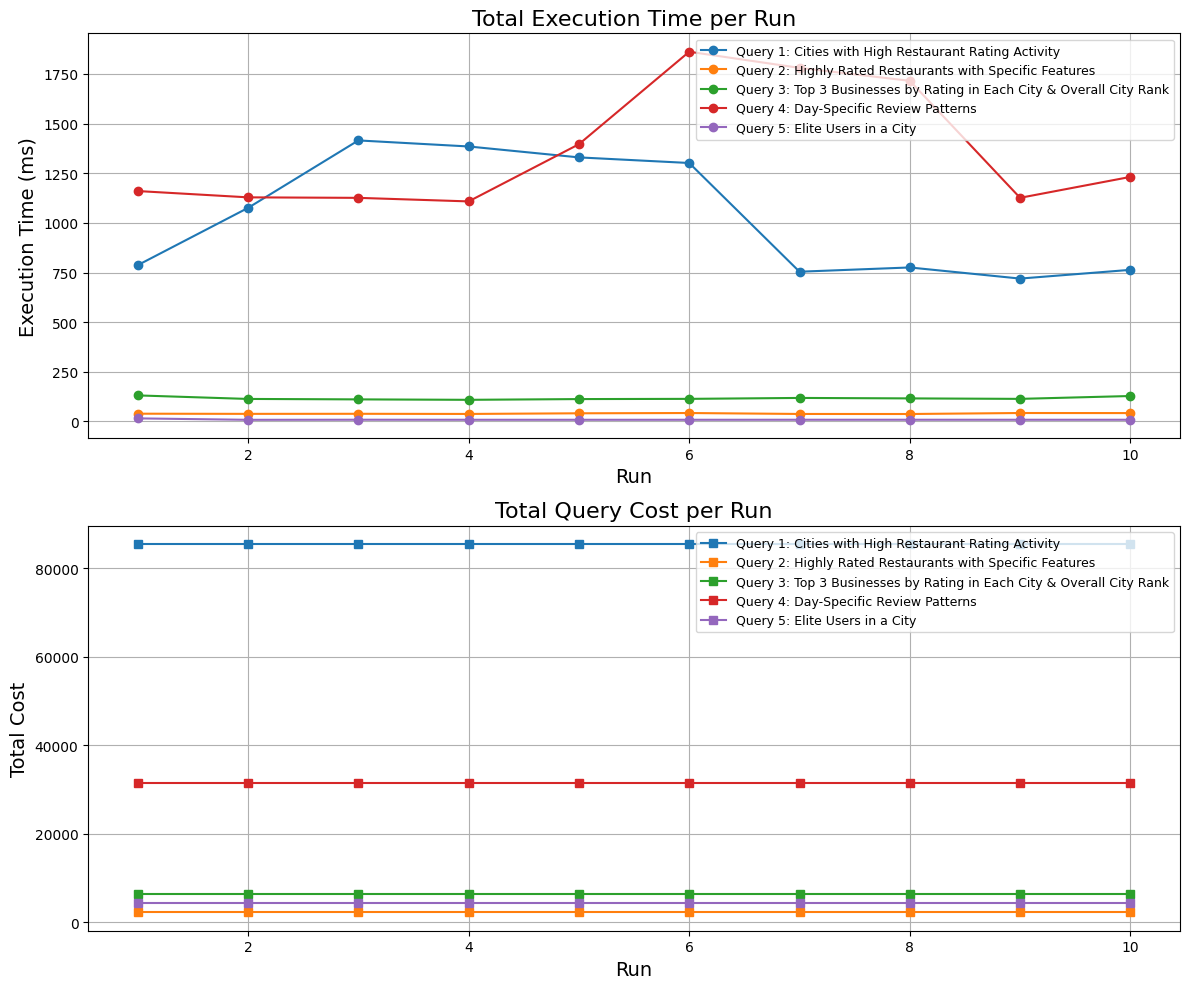

<Figure size 640x480 with 0 Axes>


✅ PostgreSQL connection closed.


In [6]:
import psycopg2
import time
import pprint
import matplotlib.pyplot as plt
import numpy as np
import json

# PostgreSQL connection
try:
    conn = psycopg2.connect(
        dbname="data101db",
        user="myuser",
        password="mypassword",
        host="localhost",
        port="5432"
    )
    pg_cur = conn.cursor()
    print("\n📂 PostgreSQL connection established!")
except Exception as e:
    print(f"❌ Error: PostgreSQL connection failed - {e}")
    raise

# Function to print formatted EXPLAIN ANALYZE results
def print_explain_analyze_results(avg_latency, avg_memory):
    print("\nEXPLAIN ANALYZE OUTPUT (AVERAGE):")
    print(f" Execution Time: {avg_latency:.2f} ms")
    if avg_memory is not None:
        print(f" Peak Memory Usage: {avg_memory:.2f} kB")

# Function to run a query multiple times and collect performance data
def execute_and_time_query(query, query_name, runs=10):
    latencies = []
    total_costs = []
    print(f"\n=== Running {query_name} ===\n")
    for i in range(runs):
        print(f"🔄 Run {i+1}/{runs}...")
        pg_cur.execute(query)
        explain_output = pg_cur.fetchone()  # Fetch one row, EXPLAIN ANALYZE returns a single row
        explain_json = explain_output[0]  # Already a Python dictionary

        # Parse EXPLAIN ANALYZE JSON output
        plan = explain_json[0]["Plan"]
        latency = plan["Actual Total Time"]  # Execution time in ms
        cost = plan["Total Cost"]  # Total query cost
        latencies.append(latency)
        total_costs.append(cost)

        print(f"⏱ Execution Time: {latency:.2f} ms")
        print(f"💰 Total Cost: {cost:.2f}\n")

    avg_latency = sum(latencies) / len(latencies)
    avg_cost = sum(total_costs) / len(total_costs)

    print(f"✅ {query_name} Completed.")
    print_explain_analyze_results(avg_latency, avg_cost)

    return latencies, total_costs



# Queries
queries = {
    "Query 1: Cities with High Restaurant Rating Activity": """
    EXPLAIN (ANALYZE, FORMAT JSON)
    SELECT
        b.city,
        COUNT(r.review_id) AS total_reviews,
        AVG(r.stars) AS avg_rating
    FROM
        Businesses b
    JOIN
        Reviews r
    ON
        b.business_id = r.business_id
    WHERE
        b.categories ILIKE '%Restaurant%'
    GROUP BY
        b.city
    ORDER BY
        total_reviews DESC
    LIMIT 10;
    """,
    "Query 2: Highly Rated Restaurants with Specific Features": """
    EXPLAIN (ANALYZE, FORMAT JSON)
    SELECT DISTINCT
        b.name,
        b.stars,
        b.address,
        b.review_count
    FROM
        Businesses b
    WHERE
        b.categories ILIKE '%Restaurant%'
        AND b.review_count >= 300
        AND b.attributes->>'RestaurantsTakeOut' = 'True'
        AND b.attributes->'BusinessParking'->>'lot' = 'True'
    ORDER BY
        b.stars DESC,
        b.review_count DESC
    LIMIT 5;
    """,
    "Query 3: Top 3 Businesses by Rating in Each City & Overall City Rank": """
    EXPLAIN (ANALYZE, FORMAT JSON)
    WITH ranked_businesses AS (
        SELECT
            name,
            city,
            stars,
            review_count,
            RANK() OVER (
                PARTITION BY city
                ORDER BY stars DESC, review_count DESC
            ) AS city_rank,
            RANK() OVER (
                ORDER BY stars DESC, review_count DESC
            ) AS overall_rank
        FROM
            Businesses
    )
    SELECT
        *
    FROM
        ranked_businesses
    WHERE
        city_rank <= 3
    ORDER BY
        city,
        city_rank;
    """,
    "Query 4: Day-Specific Review Patterns": """
    EXPLAIN (ANALYZE, FORMAT JSON)
    SELECT
        TO_CHAR(r.review_date, 'Day') AS review_day,
        COUNT(r.review_id) AS total_reviews
    FROM
        Reviews r
    JOIN
        Businesses b
    ON
        r.business_id = b.business_id
    WHERE
        b.is_open = true
        AND b.review_count > 500
    GROUP BY
        TO_CHAR(r.review_date, 'Day')
    ORDER BY
        total_reviews DESC;
    """,
    "Query 5: Elite Users in a City": """
    EXPLAIN (ANALYZE, FORMAT JSON)
    SELECT DISTINCT
        u.name,
        u.review_count,
        u.average_stars,
        u.elite
    FROM
        Users u
    JOIN
        Reviews r
    ON
        u.user_id = r.user_id
    JOIN
        Businesses b
    ON
        r.business_id = b.business_id
    WHERE
        b.city = 'Los Angeles'
        AND u.review_count > 50
    ORDER BY
        u.average_stars DESC;
    """
}

# Run all queries and collect execution times and memory usage
results = {}
runs = 10  # Number of times to run each query
for query_name, query in queries.items():
    latencies, total_costs = execute_and_time_query(query, query_name, runs=runs)
    results[query_name] = {
    "latencies": latencies,
    "total_costs": total_costs
    }


# Plot the execution times and memory usage for each query
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Execution Time Plot
for query_name, data in results.items():
    axs[0].plot(range(1, runs + 1), data["latencies"], marker="o", label=query_name)
axs[0].set_title("Total Execution Time per Run", fontsize=16)
axs[0].set_xlabel("Run", fontsize=14)
axs[0].set_ylabel("Execution Time (ms)", fontsize=14)
axs[0].legend(fontsize=9, loc="upper right")
axs[0].grid(True)

# Total Cost Plot
for query_name, data in results.items():
    axs[1].plot(range(1, runs + 1), data["total_costs"], marker="s", label=query_name)
axs[1].set_title("Total Query Cost per Run", fontsize=16)
axs[1].set_xlabel("Run", fontsize=14)
axs[1].set_ylabel("Total Cost", fontsize=14)
axs[1].legend(fontsize=9, loc="upper right")
axs[1].grid(True)

plt.tight_layout()
plt.show()


plt.tight_layout()
plt.show()

# Close PostgreSQL connection
pg_cur.close()
conn.close()
print("\n✅ PostgreSQL connection closed.")
